In [1]:
import xlwings as xw
import wget
import os
from datetime import datetime
from datetime import timedelta
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Partie 1 : Acquisition et chargement des données 

On télécharge les fichiers de classement, et on supprime les skippers qui a abandonné la course dans chaque période.

In [2]:
# pour éviter l'erreur [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired

import ssl
import urllib

ssl._create_default_https_context = ssl._create_unverified_context


In [3]:
begin_date = datetime(2020,11,9)
end_date = datetime(2021,1,26)
hour = ['04','08','11','14','17','21']
hour_begin = ['14','15','17','21']
out_path = r'C:/Users/17760/Kit-Big-Data-master/projet_final/data'

In [4]:
def dateTostr(date):
    str_date = date.strftime('%Y%m%d')
    return str_date                          

In [5]:
date_list = []
date = begin_date
while date <= end_date:  
    str_d = dateTostr(date)
    date_list.append(str_d)
    date = date + timedelta(days=1)

In [6]:
if not os.listdir(out_path):
    for d in date_list:
        for h in hour:
            url = f'https://www.vendeeglobe.org/download-race-data/vendeeglobe_{d}_{h}0000.xlsx'
            wget.download(url,out=out_path)
    for h in hour_begin:
        url = f'https://www.vendeeglobe.org/download-race-data/vendeeglobe_20201108_{h}0000.xlsx'
        wget.download(url,out=out_path)
else:
    print(f"Les fichiers Excel sont déjà téléchargées dans local")


Les fichiers Excel sont déjà téléchargées dans local


In [7]:
def prepareData(date,hour):
    
    url = f"data/vendeeglobe_{date}_{hour}0000.xlsx"
    
    with xw.Book(url, mode="r") as book:
        sheet1 = book.sheets[0]
        df = sheet1.cells.options('df').value
        df.iloc[3,:3] = df.iloc[2,:3]
        df.iloc[3,-2:] = df.iloc[2,-2:]
        df = df.iloc[3:-4]
        
        df.iloc[0,0]=df.iloc[0,0].replace('\r\nRank','')
        df.iloc[0] = df.iloc[0].str.split('\r\n').str[0]
        df.iloc[0,6:10] = df.iloc[0,6:10]+"_since30min"
        df.iloc[0,10:14] = df.iloc[0,10:14]+"_lastReport"
        df.iloc[0,14:18] = df.iloc[0,14:18]+"_since24h"
        df.columns = df.iloc[0]
        df = df.iloc[1:]
        
        df['Nationalité'] = df.iloc[:,1].str.split(' ').str[0]
        df['Nationalité'] = df.iloc[:,-1].str.split('\r\n').str[-1]
        df['Voile'] = df.iloc[:,1].str.split(' ').str[1]
        df['Skipper'] = df.iloc[:,2].str.split('\r\n').str[0]
        df['Bateau'] = df.iloc[:,2].str.split('\r\n').str[1]
        df = df.drop(['Nat. / Voile', 'Skipper / Bateau'], axis=1)
        day = datetime.strptime(date, '%Y%m%d')
        df['Date'] = day
        df = df.reset_index(drop=True)
        
        return df
        

In [8]:
data_final = pd.DataFrame()
for h in hour_begin:
        data = prepareData('20201108',h)
        data = data.dropna()
        data_final = pd.concat([data_final,data],axis=0)
for d in date_list:
    for h in hour:
        data = prepareData(d,h)
        data = data.dropna()
        data_final = pd.concat([data_final,data],axis=0)
data_final.reset_index(drop=True)
data_final.head()

,Rang,Heure FR,Latitude,Longitude,Cap_since30min,Vitesse_since30min,VMG_since30min,Distance_since30min,Cap_lastReport,Vitesse_lastReport,...,Vitesse_since24h,VMG_since24h,Distance_since24h,DTF,DTL,Nationalité,Voile,Skipper,Bateau,Date
0,1,15:30 FR\r\n,46°24.46'N,01°50.48'W,241°,17.7 kts,17.5 kts,0.3 nm,357°,0.0 kts,...,0.3 kts,0.3 kts,6.1 nm,24293.9 nm,0.0 nm,FRA,18,Louis Burton,Bureau Vallée 2,2020-11-08
1,2,15:31 FR\r\n1min,46°24.34'N,01°49.82'W,241°,11.1 kts,10.9 kts,0.4 nm,357°,0.0 kts,...,0.3 kts,0.2 kts,6.0 nm,24294.2 nm,0.4 nm,MON,10,Boris Herrmann,Seaexplorer - Yacht Club De Monaco,2020-11-08
2,3,15:30 FR\r\n,46°24.91'N,01°49.99'W,244°,15.5 kts,15.5 kts,0.5 nm,357°,0.0 kts,...,0.2 kts,0.2 kts,5.5 nm,24294.3 nm,0.5 nm,FRA,8,Jérémie Beyou,Charal,2020-11-08
3,4,15:30 FR\r\n,46°24.71'N,01°49.68'W,244°,13.2 kts,13.1 kts,0.7 nm,357°,0.0 kts,...,0.2 kts,0.2 kts,5.6 nm,24294.5 nm,0.6 nm,FRA,59,Thomas Ruyant,LinkedOut,2020-11-08
4,5,15:30 FR\r\n,46°24.59'N,01°49.56'W,246°,10.9 kts,10.9 kts,0.2 nm,357°,0.0 kts,...,0.8 kts,0.7 kts,5.8 nm,24294.5 nm,0.6 nm,FRA,53,Maxime Sorel,V And B Mayenne,2020-11-08


In [9]:
data_final.isnull().sum()

Rang                   0
Heure FR               0
Latitude               0
Longitude              0
Cap_since30min         0
Vitesse_since30min     0
VMG_since30min         0
Distance_since30min    0
Cap_lastReport         0
Vitesse_lastReport     0
VMG_lastReport         0
Distance_lastReport    0
Cap_since24h           0
Vitesse_since24h       0
VMG_since24h           0
Distance_since24h      0
DTF                    0
DTL                    0
Nationalité            0
Voile                  0
Skipper                0
Bateau                 0
Date                   0
dtype: int64

In [10]:
print(f'Le tableau final de classement contient {data_final.shape[0]} lignes et {data_final.shape[1]} colonnes.')

Le tableau final de classement contient 13603 lignes et 23 colonnes.


Ensuite,on acquiert les fichiers de caractéristiques de bateau, on le transforme dans un DataFrame en indiquant le nom du bateau et le nom de skipper.

In [11]:
url = "https://www.vendeeglobe.org/fr/glossaire"
soup = BeautifulSoup(requests.get(url).content)

In [12]:
# trouver le nom des bateaux et des skipper
boat_list = soup.find_all('h3', {"class","boats-list__boat-name"})
boat_name = []
skipper = []
for boat in boat_list:
    name_boat = boat.text
    boat_name.append(name_boat)
    name_skipper = boat.parent()[1].text.title()
    skipper.append(name_skipper)

In [13]:
boat_car = soup.find_all('ul', {"class","boats-list__popup-specs-list"})
dic_boat_final = []
for boat in boat_car:
    dic_boat = {}
    li_tag = boat.find_all('li')
    for tag in li_tag :
        dic_boat[tag.text.split(':')[0]] = tag.text.split(':')[1]
    dic_boat_final.append(dic_boat)
df_boat = pd.DataFrame(dic_boat_final)

boat_name = pd.DataFrame(boat_name,columns=['Nom du bateau'])
skipper = pd.DataFrame(skipper,columns = ['Skipper'])
carac_bateau = pd.concat([boat_name,skipper,df_boat],axis=1)

carac_bateau.head()

,Nom du bateau,Skipper,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,NEWREST - ART & FENÊTRES,Fabrice Amedeo,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,"18,28 m","5,85 m","4,50 m",7 t,foils,29 m,monotype,320 m2,570 m2
1,PURE - Best Western®,Romain Attanasio,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,"18,28m","5,80m","4,50m",9t,2,28m,acier forgé,280 m2,560 m2
2,TSE - 4MYPLANET,Alexia Barrier,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeu...",Marc Lombard,MAG France,01 Mars 1998,"18,28m","5,54m","4,50m",9t,2,29 m,acier,260 m2,580 m2
3,Maître CoQ IV,Yannick Bestaven,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,"18,28 m","5,80 m","4,50 m",8 t,foils,29 m,acier mécano soudé,310 m2,550 m2
4,CHARAL,Jérémie Beyou,08,NaN,VPLP,CDK Technologies,18 Août 2018,"18,28 m","5,85 m","4,50 m",8t,foils,29 m,acier,320 m2,600 m2


In [14]:
carac_bateau.isnull().sum(axis=1)

0      0
1      0
2      0
3      0
4      1
5      0
6      0
7      0
8      0
9      0
10     1
11     0
12     0
13     0
14     1
15     0
16    13
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     2
27     0
28     1
29     1
30     0
31     1
32     1
33     2
dtype: int64

Vu que pour le skipper 'François Guiffant', on a presque aucune information sur son bateau, donc il ne sert pas à faire l'analyse, par conséquence, on le supprime de la liste.

In [15]:
carac_bateau = carac_bateau.drop(16, axis=0)
carac_bateau = carac_bateau.reset_index(drop=True)

In [16]:
print(f'Le tableau final de caratéristique de bateau contient {carac_bateau.shape[0]} bateaux, avec {carac_bateau.shape[1]} colonnes')

Le tableau final de caratéristique de bateau contient 33 bateaux, avec 16 colonnes


## Partie 2 : Préparation des données

#### Extraction des caractéristiques techniques de chacun des voiliers.

In [17]:
n = [7,8,9,10,12,14,15,11]
tech_boat = carac_bateau.iloc[:,n].copy()
pd.options.mode.chained_assignment = None  

In [18]:
tech_boat = tech_boat.stack().str.replace(',','.').unstack()

In [19]:
tech_boat.iloc[14,3]=None
tech_boat.iloc[24,3]=None

In [20]:
c_num = ['Longueur ', 'Largeur ', 'Tirant d\'eau ', 
       'Hauteur mât ','Surface de voiles au près ', 'Surface de voiles au portant ']
for c in c_num:
    tech_boat[c] = [float(v[0]) for v in tech_boat[c].str.split('m')]
    
list1 = tech_boat['Déplacement (poids) '].str.split('t')
for i in range(len(tech_boat)):
    if tech_boat['Déplacement (poids) '][i]:
        tech_boat['Déplacement (poids) '][i] = float(list1[i][0])
    else:
        pass
    
tech_boat

,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Hauteur mât,Surface de voiles au près,Surface de voiles au portant,Nombre de dérives
0,18.28,5.85,4.5,7.0,29.0,320.0,570.0,foils
1,18.28,5.80,4.5,9.0,28.0,280.0,560.0,2
2,18.28,5.54,4.5,9.0,29.0,260.0,580.0,2
3,18.28,5.80,4.5,8.0,29.0,310.0,550.0,foils
4,18.28,5.85,4.5,8.0,29.0,320.0,600.0,foils
5,18.28,5.65,4.5,7.9,29.0,300.0,610.0,foils
6,18.28,5.80,4.5,7.6,28.0,300.0,600.0,foils
7,18.28,5.30,4.5,8.9,26.0,240.0,470.0,2
8,18.28,5.80,4.5,9.0,28.5,270.0,560.0,2 asymétriques
9,18.28,5.70,4.5,7.7,29.0,340.0,570.0,2


On remplit les valeurs manquants dans la colonne poids par la méthode KNN Regression

In [21]:
index = list(range(32))
index.remove(14)
index.remove(24)

x_train = tech_boat.iloc[index,[0,1,2,4,5,6]]
y_train = tech_boat.iloc[index,3]
x_pred = tech_boat.iloc[:,[0,1,2,4,5,6]]
neigh = KNeighborsRegressor(n_neighbors=3)
neigh.fit(x_train, y_train)
tech_boat.iloc[14,3] = round(neigh.predict(x_pred)[14],1)
tech_boat.iloc[24,3] = round(neigh.predict(x_pred)[24],1)

tech_boat

,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Hauteur mât,Surface de voiles au près,Surface de voiles au portant,Nombre de dérives
0,18.28,5.85,4.5,7.0,29.0,320.0,570.0,foils
1,18.28,5.80,4.5,9.0,28.0,280.0,560.0,2
2,18.28,5.54,4.5,9.0,29.0,260.0,580.0,2
3,18.28,5.80,4.5,8.0,29.0,310.0,550.0,foils
4,18.28,5.85,4.5,8.0,29.0,320.0,600.0,foils
5,18.28,5.65,4.5,7.9,29.0,300.0,610.0,foils
6,18.28,5.80,4.5,7.6,28.0,300.0,600.0,foils
7,18.28,5.30,4.5,8.9,26.0,240.0,470.0,2
8,18.28,5.80,4.5,9.0,28.5,270.0,560.0,2 asymétriques
9,18.28,5.70,4.5,7.7,29.0,340.0,570.0,2


In [22]:
# On rajoute les noms de skippers dans la tableau de caratéristique technique des voiliers
tech_boat['Skipper'] = carac_bateau['Skipper']
tech_boat.head()

,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Hauteur mât,Surface de voiles au près,Surface de voiles au portant,Nombre de dérives,Skipper
0,18.28,5.85,4.5,7.0,29.0,320.0,570.0,foils,Fabrice Amedeo
1,18.28,5.80,4.5,9.0,28.0,280.0,560.0,2,Romain Attanasio
2,18.28,5.54,4.5,9.0,29.0,260.0,580.0,2,Alexia Barrier
3,18.28,5.80,4.5,8.0,29.0,310.0,550.0,foils,Yannick Bestaven
4,18.28,5.85,4.5,8.0,29.0,320.0,600.0,foils,Jérémie Beyou


#### Rapprochement des données des voiliers avec celle des classements.

In [23]:
# Créer une colonne id pour facilier la fusion des 2 tableaux
nom_skipper = data_final['Skipper'].unique()
list_id = list(range(33))
mapping_id = {}
for i in range(len(list_id)):
    key = nom_skipper[i]
    mapping_id[key] = list_id[i]
data_final['id'] = data_final['Skipper'].map(mapping_id)
tech_boat['id'] = tech_boat['Skipper'].map(mapping_id)
tech_boat.iloc[5,9] = 32
tech_boat.iloc[11,9] = 15
tech_boat.iloc[24,9] = 22

In [24]:
car_list = list(tech_boat.columns)
car_list.remove('Skipper')
car_list.remove('id')
car_list

['Longueur ',
 'Largeur ',
 "Tirant d'eau ",
 'Déplacement (poids) ',
 'Hauteur mât ',
 'Surface de voiles au près ',
 'Surface de voiles au portant ',
 'Nombre de dérives ']

In [25]:
for col in car_list:
    data_final[col] = data_final['id'].apply(lambda x: tech_boat[tech_boat['id']==x][col].values[0])
data_final.head()

,Rang,Heure FR,Latitude,Longitude,Cap_since30min,Vitesse_since30min,VMG_since30min,Distance_since30min,Cap_lastReport,Vitesse_lastReport,...,Date,id,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Hauteur mât,Surface de voiles au près,Surface de voiles au portant,Nombre de dérives
0,1,15:30 FR\r\n,46°24.46'N,01°50.48'W,241°,17.7 kts,17.5 kts,0.3 nm,357°,0.0 kts,...,2020-11-08,0,18.28,5.80,4.5,7.6,28.0,300.0,600.0,foils
1,2,15:31 FR\r\n1min,46°24.34'N,01°49.82'W,241°,11.1 kts,10.9 kts,0.4 nm,357°,0.0 kts,...,2020-11-08,1,18.28,5.70,4.5,7.6,29.0,290.0,490.0,foils
2,3,15:30 FR\r\n,46°24.91'N,01°49.99'W,244°,15.5 kts,15.5 kts,0.5 nm,357°,0.0 kts,...,2020-11-08,2,18.28,5.85,4.5,8.0,29.0,320.0,600.0,foils
3,4,15:30 FR\r\n,46°24.71'N,01°49.68'W,244°,13.2 kts,13.1 kts,0.7 nm,357°,0.0 kts,...,2020-11-08,3,18.28,5.85,4.5,8.0,29.0,350.0,560.0,foils
4,5,15:30 FR\r\n,46°24.59'N,01°49.56'W,246°,10.9 kts,10.9 kts,0.2 nm,357°,0.0 kts,...,2020-11-08,4,18.28,5.50,4.5,7.7,29.0,365.0,700.0,2


In [26]:
data_final.shape

(13603, 32)

#### Préparer les données pour faire la régression linéaire.

In [27]:
col_skipper = ['Skipper','Rang','VMG_since30min','VMG_lastReport','VMG_since24h',
       'Vitesse_since30min','Vitesse_lastReport','Vitesse_since24h','Nombre de dérives ',
       'Distance_since30min','Distance_lastReport','Distance_since24h','DTF','DTL','Date']

col_num = ['VMG_since30min','VMG_lastReport','VMG_since24h',
       'Vitesse_since30min','Vitesse_lastReport','Vitesse_since24h',
       'Distance_since30min','Distance_lastReport','Distance_since24h','DTF','DTL']

v_ana = data_final.loc[:,col_skipper]

v_ana['Rang'] = v_ana['Rang'].astype('int')

for col in col_num:
    v_ana[col] = [float(a[0]) for a in v_ana[col].str.split(' ')]
    
v_ana.head()

,Skipper,Rang,VMG_since30min,VMG_lastReport,VMG_since24h,Vitesse_since30min,Vitesse_lastReport,Vitesse_since24h,Nombre de dérives,Distance_since30min,Distance_lastReport,Distance_since24h,DTF,DTL,Date
0,Louis Burton,1,17.5,0.0,0.3,17.7,0.0,0.3,foils,0.3,2788.0,6.1,24293.9,0.0,2020-11-08
1,Boris Herrmann,2,10.9,0.0,0.2,11.1,0.0,0.3,foils,0.4,2787.9,6.0,24294.2,0.4,2020-11-08
2,Jérémie Beyou,3,15.5,0.0,0.2,15.5,0.0,0.2,foils,0.5,2788.5,5.5,24294.3,0.5,2020-11-08
3,Thomas Ruyant,4,13.1,0.0,0.2,13.2,0.0,0.2,foils,0.7,2788.3,5.6,24294.5,0.6,2020-11-08
4,Maxime Sorel,5,10.9,0.0,0.7,10.9,0.0,0.8,2,0.2,2788.1,5.8,24294.5,0.6,2020-11-08


## Partie 3 : Analyses et story telling

#### Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers

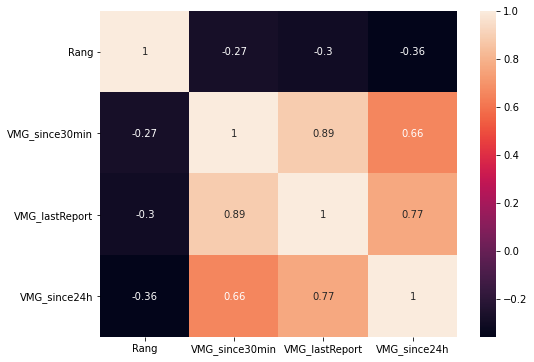

In [28]:
vmg = v_ana.loc[:,['Skipper','Rang','VMG_since30min','VMG_lastReport','VMG_since24h']]

df_corr = vmg.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(df_corr, annot=True)
plt.show()

In [29]:
df = vmg.groupby('Skipper').mean()

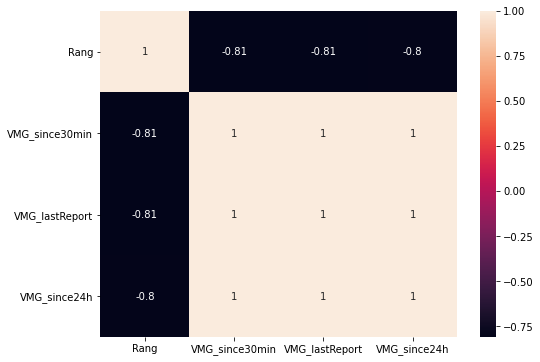

In [30]:
df_corr = df.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(df_corr, annot=True)
plt.show()

In [31]:
x = df.iloc[:,-1:]
y = df.iloc[:,0]

In [32]:
def regVmg (vitesse,rang):
    x_train, x_test, y_train, y_test = train_test_split(vitesse, rang, test_size=0.25)
    data = LinearRegression().fit(x_train,y_train)
    y_pred = data.predict(x_test)
    score = data.score(x_test,y_test)
    return score

In [33]:
list_score = []
for i in range(100):
    res = regVmg(x,y)
    list_score.append(round(res,2))
print(list_score)
print('la score moyenne en appliquant indépendamment 100 fois la regression linéaire sur les données est : ', np.mean(list_score))

[0.74, 0.7, -0.13, 0.02, 0.23, 0.73, 0.79, -0.98, 0.67, 0.82, 0.56, 0.8, -0.1, 0.13, 0.76, 0.66, 0.6, 0.72, 0.35, 0.76, 0.72, 0.66, 0.18, 0.73, 0.79, 0.39, 0.58, 0.84, 0.58, 0.39, 0.67, 0.79, 0.76, 0.57, 0.09, 0.65, 0.59, 0.75, -0.05, 0.66, 0.85, 0.73, 0.84, 0.72, 0.81, 0.8, 0.68, 0.42, 0.83, 0.42, 0.05, 0.91, 0.53, 0.61, 0.23, 0.83, 0.82, 0.84, 0.62, 0.75, 0.62, -1.08, 0.25, 0.8, 0.62, 0.9, 0.76, 0.79, 0.71, -0.09, 0.73, 0.56, 0.27, -0.01, 0.79, 0.5, 0.79, 0.83, 0.78, 0.8, 0.75, 0.86, 0.51, 0.66, 0.75, 0.78, 0.77, 0.09, 0.76, 0.73, 0.25, 0.86, 0.58, -0.07, 0.52, 0.8, 0.29, 0.39, 0.63, 0.14]
la score moyenne en appliquant indépendamment 100 fois la regression linéaire sur les données est :  0.5483


Conclusion : On peut voir que parfois on obtient un résultat presque parfait avec un score de R2 égale à 0.98, mais parfois le score est très bas, c'est peut-être à cause de la façon aléatoire de séparation entre les données d'entrainement de les données de test. 

Text(0.5, 1.0, 'Corrélation et régression linéaire entre le rang et la VMG')

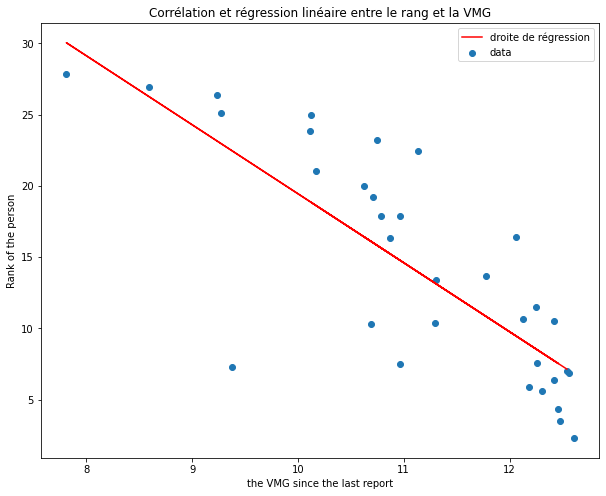

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25)
data = LinearRegression().fit(x_train,y_train)
y_pred = data.predict(x_test)

plt.figure(figsize=(10,8))
plt.scatter(x,y,label='data')
plt.xlabel('the VMG since the last report')
plt.ylabel('Rank of the person')

plt.plot(x_test,y_pred,'r',label='droite de régression')
    
plt.legend()
plt.title('Corrélation et régression linéaire entre le rang et la VMG')

#### Impact de la présence d'un foil sur le classement et la vitesse des voiliers.

In [35]:
df2 = v_ana.loc[:,['Rang','Vitesse_since30min','Vitesse_lastReport','Vitesse_since24h','Nombre de dérives ']]

In [36]:
f = df2.groupby('Nombre de dérives ').mean()
f

,Rang,Vitesse_since30min,Vitesse_lastReport,Vitesse_since24h
Nombre de dérives,,,,
2,17.180887,12.457305,12.245506,11.753015
2 asymétriques,21.029289,12.279916,11.909623,11.386192
foiler,10.398734,14.397468,14.004430,13.120886
foils,12.436308,13.873965,13.546493,12.872204


Text(0.5, 1.0, "Impact de la présence d'un foil ")

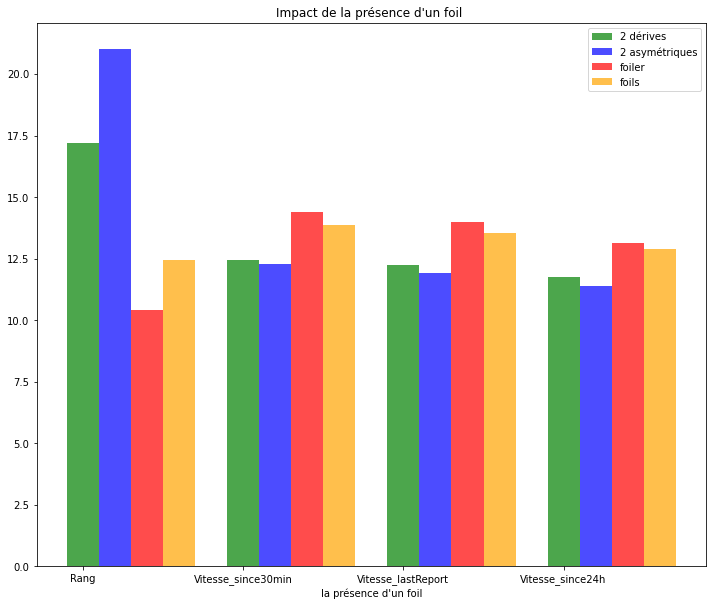

In [37]:
plt.figure(figsize=(12,10))

x = ['Rang','Vitesse_since30min','Vitesse_lastReport','Vitesse_since24h']
y1 = f.iloc[0,:]
y2 = f.iloc[1,:]
y3 = f.iloc[2,:]
y4 = f.iloc[3,:]

X_axis = np.arange(len(x))
plt.bar(X_axis, y1, align='center', facecolor='green', alpha=0.7,width = 0.2,label = '2 dérives')
plt.bar(X_axis+0.2, y2, align='center', facecolor='blue', alpha=0.7,width = 0.2,label = '2 asymétriques')
plt.bar(X_axis+0.4, y3, align='center', facecolor='red', alpha=0.7,width = 0.2,label = 'foiler')
plt.bar(X_axis+0.6, y4, align='center', facecolor='orange', alpha=0.7,width = 0.2,label = 'foils')

plt.xticks(X_axis, x)
plt.xlabel('la présence d\'un foil')
plt.legend()
plt.title('Impact de la présence d\'un foil ')


Conclusion : On peut voir que avec la présence d'un foil, le classement est généralement plus haut que celle qui n'a pas de foil, et la vitesse des voiliers est aussi plus rapide. Donc on peut conclure que la présence d'un foil a une influence positif sur la course.

#### Visualisation de la distance parcourue par voilier.

In [38]:
df3 = v_ana.loc[:,['Skipper','DTF','DTL','Date']]

In [39]:
def dist(nom):
    df = df3[df3['Skipper']==nom]
    d = df['DTF']
    x = df['Date']
    return d,x

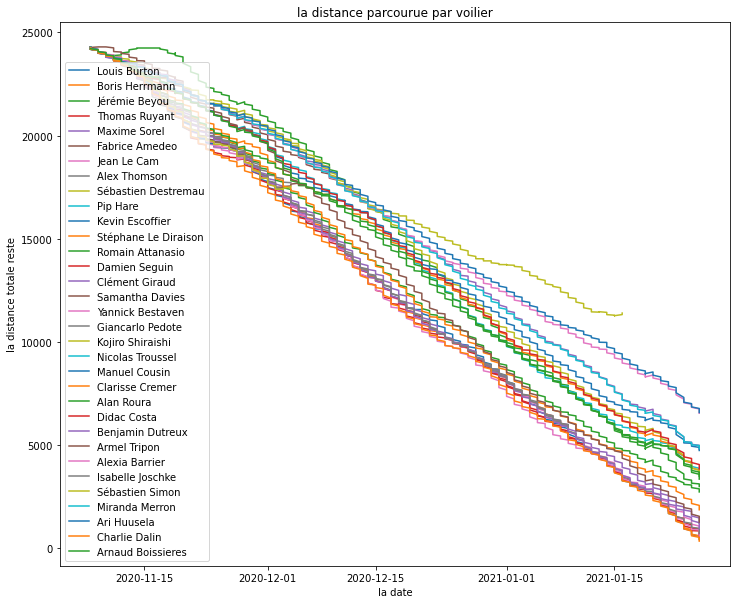

In [40]:

plt.figure(figsize=(12,10))
for name in df3['Skipper'].unique():
    x = dist(name)[1]
    y = dist(name)[0]
    plt.plot(x,y,label=name)
    
plt.xlabel('la date')
plt.ylabel('la distance totale reste')
plt.title('la distance parcourue par voilier')
plt.legend()